In [1]:
import numpy as np
import pandas as pd
from scipy import spatial

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# import matplotlib
# matplotlib.use("nbagg")

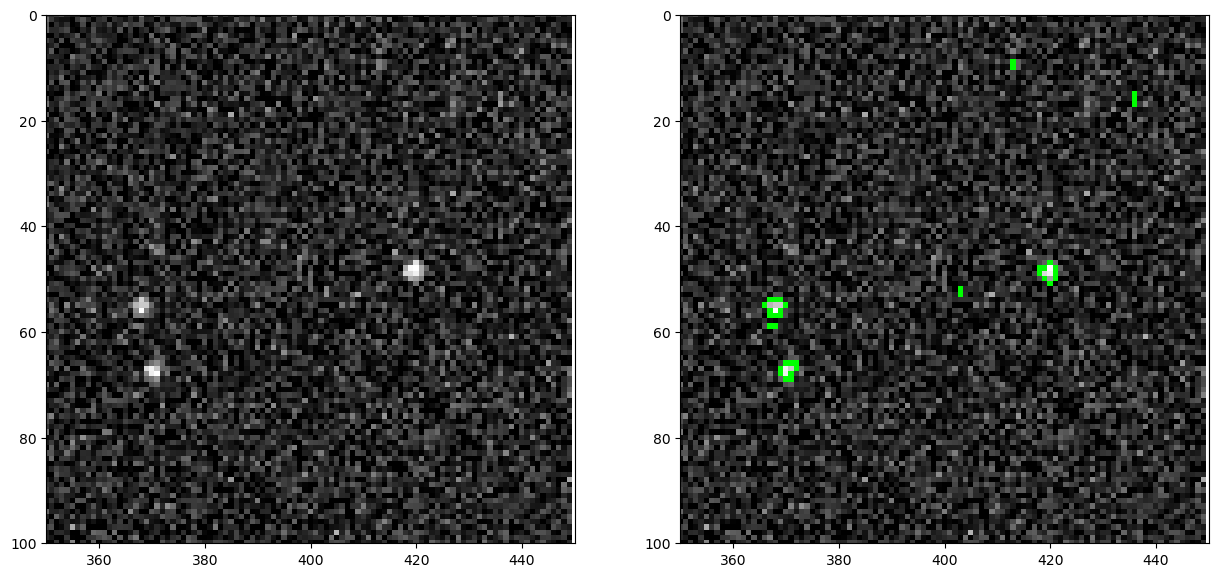

In [2]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

# Read the first image [y, x], convert to grayscale
img_rgb = cv.imread('PTV/a1.png')
img = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

# Bilateral filter
# VALUES WITHOUT TRHESHOLD:
# img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=50, sigmaSpace=7)
# img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=20, sigmaSpace=3)
img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=50, sigmaSpace=9)
img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=20, sigmaSpace=3)

# Rest of noise to zero
_, img_proc = cv.threshold(img_proc, 50, 255, cv.THRESH_TOZERO)

# Open the image
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
# img_proc = cv.morphologyEx(img_proc, cv.MORPH_TOPHAT, kernel)
# img_proc = img_proc-img_tophat
kernel = np.ones((1,1),np.uint8)
img_proc = cv.morphologyEx(img_proc, cv.MORPH_OPEN, kernel)


# Perform a hit-or-miss transform on a binary version to remove all pixels with 
# only black neighbours on all sides
kernel = np.int8([[0, -1, 0],
                  [-1, +1, -1],
                  [0, -1, 0]])
img_binary = cv.threshold(img_proc, 0, 255, cv.THRESH_BINARY)[1]
img_singles = cv.morphologyEx(img_binary, cv.MORPH_HITMISS, kernel)
img_proc[img_singles == 255] = 0


# Find the contours
contours, _ = cv.findContours(img_proc, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
img_cnt = img_rgb.copy()
img_cnt = cv.drawContours(img_cnt, contours, -1, (0,255,0), 1)

# Show the image and the processed image next to each other
# roi = [100, 200, 100, 200]
# roi = [0, 100, 0, 100]
roi = [860, 0, 0, 450]
roi = [100, 0, 350, 450]

fig, ax = plt.subplots(1,2, figsize = (15, 15))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_cnt)
# ax[1].imshow(img_proc, cmap = 'gray')

ax[0].set_xlim(roi[2], roi[3])
ax[0].set_ylim(roi[0], roi[1])

ax[1].set_xlim(roi[2], roi[3])
ax[1].set_ylim(roi[0], roi[1])
plt.show()

(300.0, 0.0)

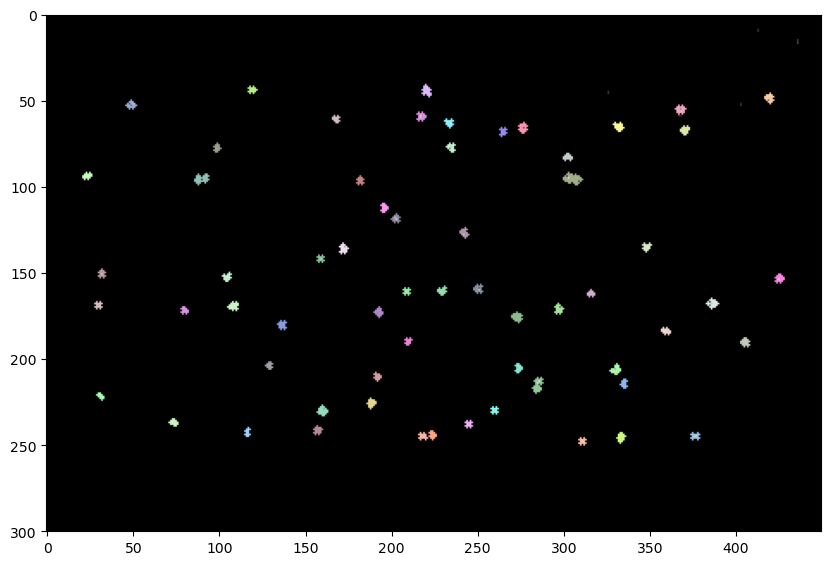

In [7]:
# Filter out contours that are too small
contours_filter = [cnt for cnt in contours if cv.contourArea(cnt) > 1]

# Draw the filtered contours, each in different colours
img_cnt2 = img_rgb.copy()
img_cnt2 = cv.cvtColor(img_proc.copy(), cv.COLOR_BGR2RGB)
for cnt in contours_filter:
    # Generate colour
    color = np.random.randint(127, 255, 3, dtype=np.uint8)
    img_cnt2 = cv.drawContours(img_cnt2, cnt, -1, 
                               (int(color[0]), int(color[1]), int(color[2])), 2)

# Show the image and the processed image next to each other
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.imshow(img_cnt2)
ax.set_ylim(300, 0)

(100.0, 50.0)

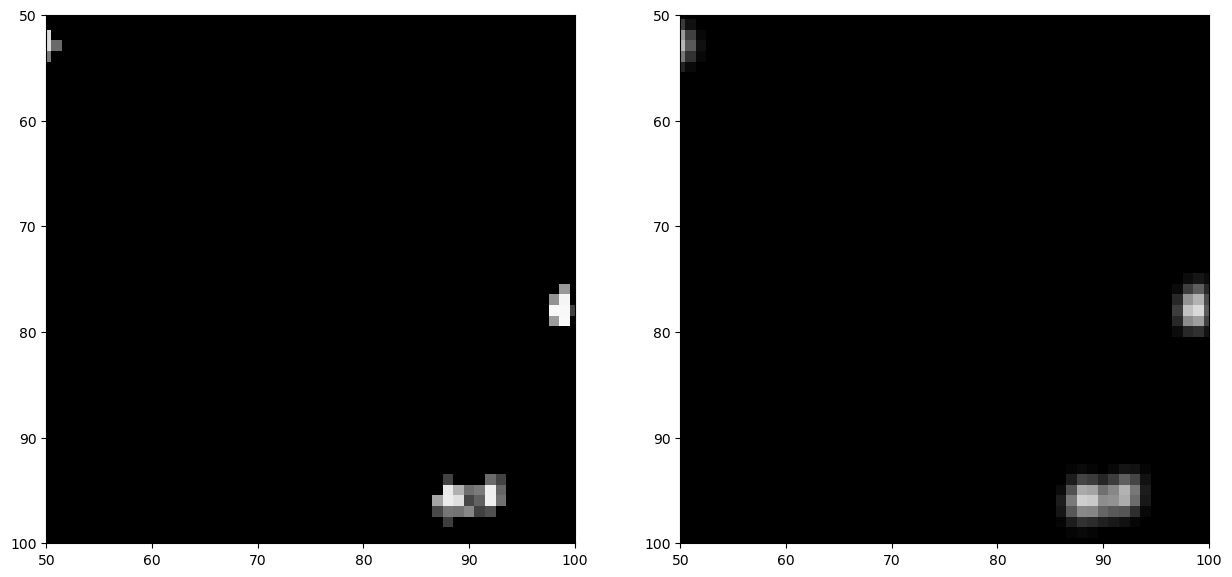

In [12]:
# Blur the image with a Gaussian filter
img_gauss = cv.GaussianBlur(img_proc, (3, 3), 0, 0)

# Get local maxima


# Plot the image and the original next to each other
fig, ax = plt.subplots(1,2, figsize = (15, 15))
ax[0].imshow(img_proc, cmap = 'gray')
ax[1].imshow(img_gauss, cmap = 'gray')

# Zoom in on roi
roi = [100, 50, 50, 100]
ax[0].set_xlim(roi[2], roi[3])
ax[0].set_ylim(roi[0], roi[1])

ax[1].set_xlim(roi[2], roi[3])
ax[1].set_ylim(roi[0], roi[1])

In [ ]:
# Simple blob detection
detector = cv.SimpleBlobDetector()

# Detect blobs.
keypoints = detector.detect(img_proc)

# Draw detected blobs as red circles.
# cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
img_with_keypoints = cv.drawKeypoints(img_proc, keypoints, np.array([]), 
                                      (0, 255, 0),
                                      cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
fig, ax = plt.subplots(1,1, figsize = (15, 15))

ax.imshow(img_with_keypoints, cmap = 'gray')
ax.set_xlim(roi[2], roi[3])
ax.set_ylim(roi[0], roi[1])
plt.show()
